In [ ]:
import sys
import os

# 確認工作目錄
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# 確保專案根目錄在 sys.path 中 (通常預設就在，但為了保險起見)
if current_dir not in sys.path:
    sys.path.append(current_dir)
    print(f"Added {current_dir} to sys.path")

# 注意：我們不再將 'src' 加入 sys.path，因為我們現在使用 'from src.xxx import yyy' 的方式
# 這樣可以避免模組名稱衝突並保持結構清晰

## 1. 啟動遊戲 (PvP / PvAI)
執行下方儲存格以開啟遊戲視窗。

In [ ]:
import sys
from PyQt5.QtWidgets import QApplication
from src.New_moon_game import MainWindow
from src.ai_logic import GreedyAI, AlphazeroAI
import os

# 確保只有一個 QApplication 實例
app = QApplication.instance()
if app is None:
    app = QApplication(sys.argv)

# 設定 AI (可選)
# P2 使用 AlphaZero (如果模型存在)，否則使用 GreedyAI
model_path = os.path.join(current_dir, 'models', 'alphazero_model.h5')
if os.path.exists(model_path):
    print("Loading AlphaZero AI...")
    # 注意：這裡需要知道 input_dim 和 num_actions，通常從 train_alphazero 導入或寫死
    # 為了簡化，這裡假設使用預設地圖 (Large)
    from src.adj_map import DEFAULT_BOARD
    NUM_NODES = len(DEFAULT_BOARD.adj_map)
    INPUT_DIM = 12 * NUM_NODES + 27
    NUM_ACTIONS = 3 * NUM_NODES
else:
    print("Model not found")

# AlphazeroAI('AlphaZero', model_path=model_path, input_dim=INPUT_DIM, num_actions=NUM_ACTIONS)
ai_players = {
    'P2': AlphazeroAI('AlphaZero', model_path=model_path, input_dim=INPUT_DIM, num_actions=NUM_ACTIONS)
}

window = MainWindow(ai_players=ai_players)
window.show()

# 在 Notebook 中執行 PyQt5 事件迴圈
app.exec_()

## 2. 視覺化訓練 (Training with UI)
執行下方儲存格以開啟訓練視窗，即時觀看 AlphaZero 自我對戰與學習過程。

In [ ]:
import sys
from PyQt5.QtWidgets import QApplication
from src.train_with_ui import TrainingWindow

app = QApplication.instance()
if app is None:
    app = QApplication(sys.argv)

train_window = TrainingWindow()
train_window.show()

app.exec_()

## 3. 背景訓練 (Headless Training)
如果不想要 UI，可以直接執行背景訓練腳本。

In [ ]:
from src.train_alphazero import train
# 開始訓練 (會佔用此 Kernel 直到手動停止)
train()

## 4. 訓練數據分析 (Training Analysis)
讀取 `models/training_history.pkl` 並繪製 Loss 曲線與勝率變化。

已載入訓練紀錄：共 48 Epochs


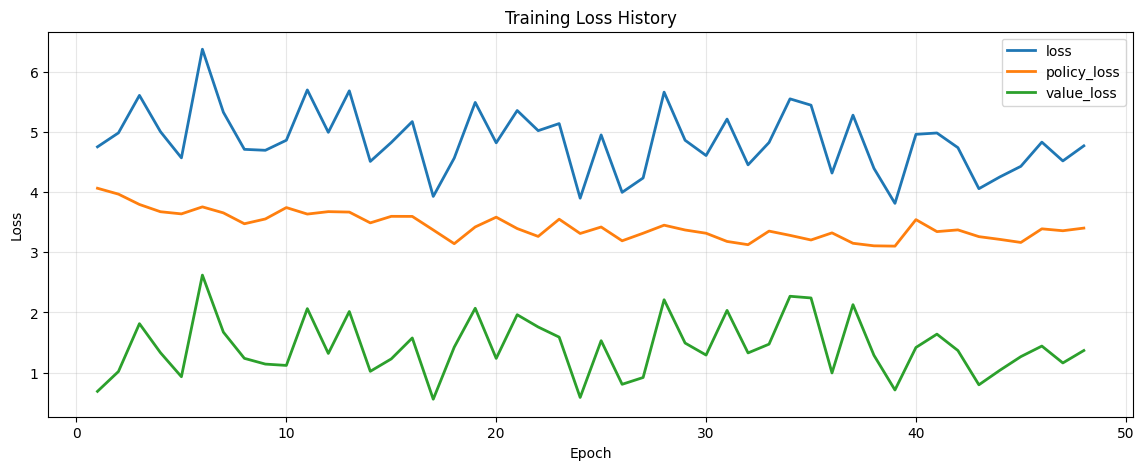

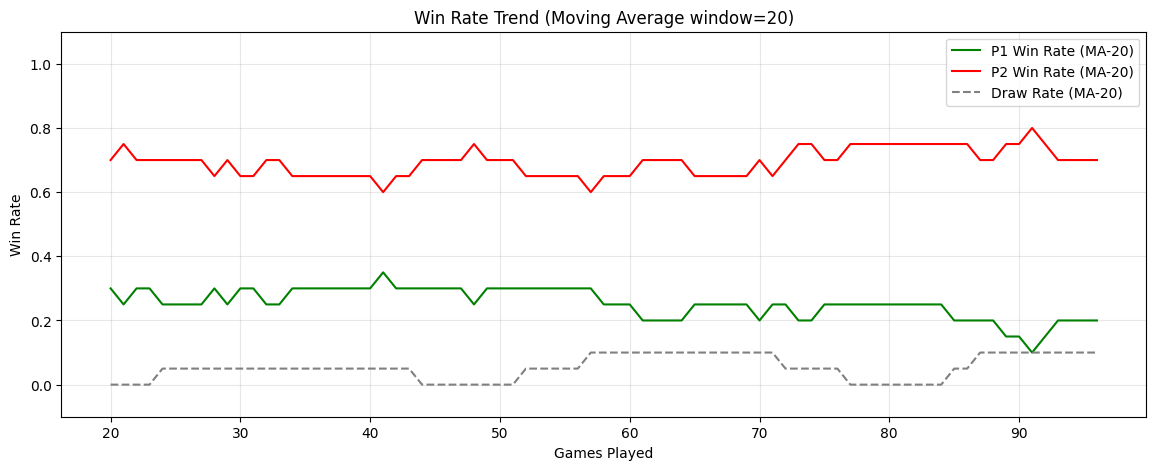

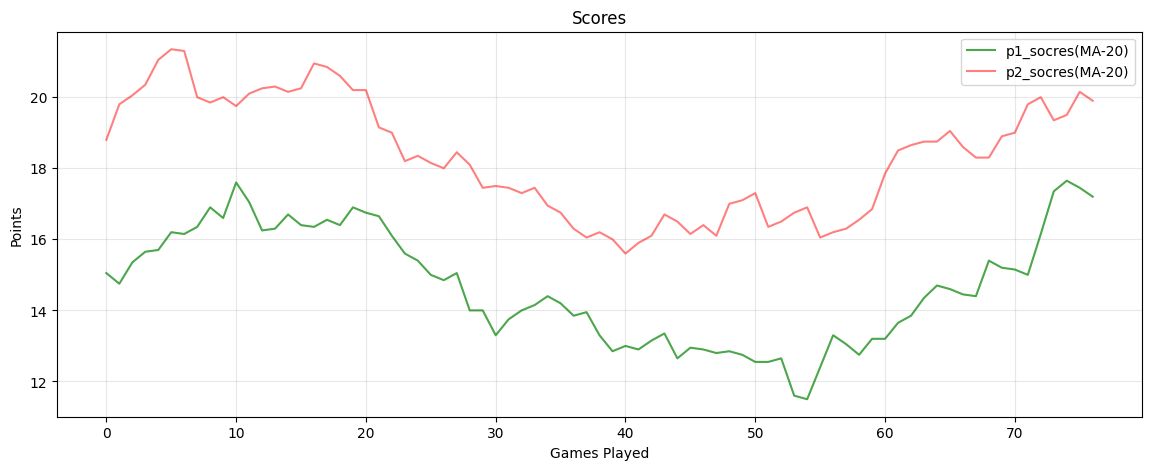

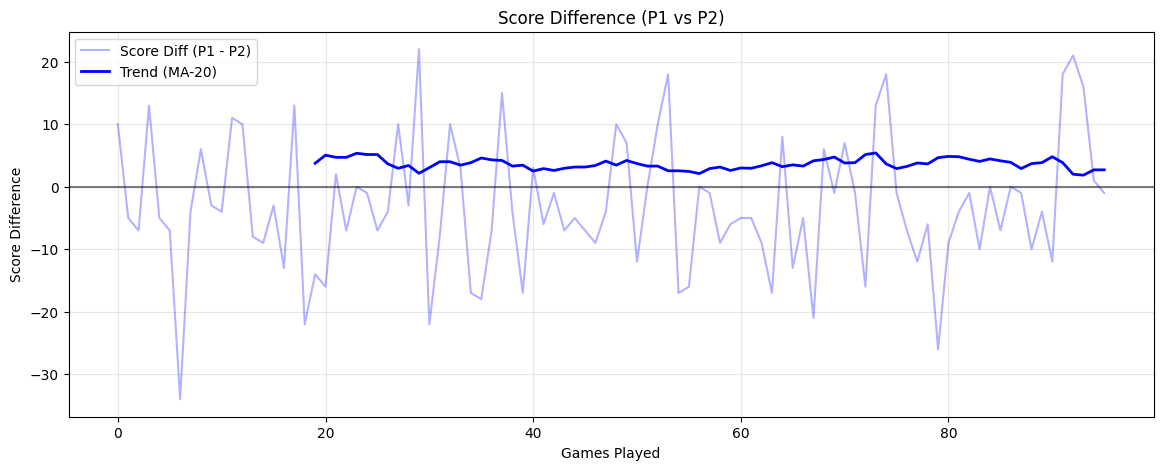


Recent Games:
Game 92: Winner=P1, Score=34-16, Steps=24
Game 93: Winner=P1, Score=30-9, Steps=24
Game 94: Winner=P1, Score=30-14, Steps=24
Game 95: Winner=P1, Score=18-17, Steps=24
Game 96: Winner=P2, Score=17-18, Steps=24


In [3]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np

# 設定路徑
history_path = os.path.join(os.getcwd(), 'models', 'training_history.pkl')

if not os.path.exists(history_path):
    print(f"尚未找到訓練紀錄: {history_path}")
    print("請先執行訓練 (Training) 以產生數據。")
else:
    try:
        with open(history_path, 'rb') as f:
            data = pickle.load(f)
            # 相容性檢查：確保數據格式正確
            if len(data) == 3:
                epoch, loss_history, game_record = data
                print(f"已載入訓練紀錄：共 {epoch} Epochs")
            else:
                print("紀錄格式不符，無法分析。")
                epoch, loss_history, game_record = 0, [], []
    except Exception as e:
        print(f"讀取錯誤: {e}")
        loss_history = []
        game_record = []

    # --- 1. 繪製 Loss 曲線 ---
    if loss_history:
        plt.figure(figsize=(14, 5))
        
        # 取得所有可用的 loss key (例如 'loss', 'policy_loss', 'value_loss')
        keys = loss_history[0].keys()
        epochs_range = range(1, len(loss_history) + 1)
        
        for key in keys:
            vals = [x[key] for x in loss_history]
            plt.plot(epochs_range, vals, label=key, linewidth=2)
            
        plt.title('Training Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # --- 2. 繪製對戰結果分析 ---
    if game_record:
        # 計算移動平均函數
        def moving_average(data, window_size=10):
            return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

        # 提取勝負數據
        p1_wins = [1 if g['winner'] == 'P1' else 0 for g in game_record]
        p2_wins = [1 if g['winner'] == 'P2' else 0 for g in game_record]
        draws = [1 if g['winner'] == 'Draw' else 0 for g in game_record]
        
        window = min(20, len(game_record))
        if window > 1:
            plt.figure(figsize=(14, 5))
            
            x_axis = range(window, len(game_record) + 1)
            
            plt.plot(x_axis, moving_average(p1_wins, window), label=f'P1 Win Rate (MA-{window})', color='green')
            plt.plot(x_axis, moving_average(p2_wins, window), label=f'P2 Win Rate (MA-{window})', color='red')
            plt.plot(x_axis, moving_average(draws, window), label=f'Draw Rate (MA-{window})', color='gray', linestyle='--')
            
            plt.title(f'Win Rate Trend (Moving Average window={window})')
            plt.xlabel('Games Played')
            plt.ylabel('Win Rate')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.ylim(-0.1, 1.1)
            plt.show()
        
        # 分別顯示分數
        p1_scores = [g['p1_score'] for g in game_record]
        p2_scores = [g['p2_score'] for g in game_record]
        
        plt.figure(figsize=(14, 5))
        plt.plot(moving_average(p1_scores, 20), alpha=0.7, color='green', label='p1_socres(MA-20)')
        plt.plot(moving_average(p2_scores, 20), alpha=0.5, color='red', label='p2_socres(MA-20)')
        plt.title('Scores')
        plt.xlabel('Games Played')
        plt.ylabel('Points')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        
        # 提取分數差數據
        score_diffs = [g['p1_score'] - g['p2_score'] for g in game_record]
        
        plt.figure(figsize=(14, 5))
        plt.plot(score_diffs, alpha=0.3, color='blue', label='Score Diff (P1 - P2)')
        if len(score_diffs) >= window:
            plt.plot(range(window-1, len(score_diffs)), abs(moving_average(score_diffs, window)), color='blue', linewidth=2, label=f'Trend (MA-{window})')
            
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('Score Difference (P1 vs P2)')
        plt.xlabel('Games Played')
        plt.ylabel('Score Difference')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # 顯示最近 5 場數據
        print("\nRecent Games:")
        for i, g in enumerate(game_record[-5:]):
            print(f"Game {len(game_record)-4+i}: Winner={g['winner']}, Score={g['p1_score']}-{g['p2_score']}, Steps={g['steps']}")